In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint, shuffle
from sklearn.metrics import accuracy_score, RocCurveDisplay
from collections import defaultdict, Counter

In [2]:
cards_meta = pd.read_json("cards_meta.json").T
cards_meta.head()

,rarity,color,card_type,cost
Immolate,RARE,RED,ATTACK,2
Riddle With Holes,UNCOMMON,GREEN,ATTACK,2
Self Repair,UNCOMMON,BLUE,POWER,1
Quick Slash,COMMON,GREEN,ATTACK,1
BootSequence,UNCOMMON,BLUE,SKILL,0


In [3]:
card_rarity = cards_meta["rarity"]
card_color = cards_meta["color"]
card_type = cards_meta["card_type"]

In [4]:
df_state_train = pd.read_json("deck_states_train.json")
df_state_test = pd.read_json("deck_states_test.json")
df_state = pd.read_json("deck_states_full.json")

In [5]:
df_cards_test = pd.read_json("cards_seen_picked_test.json")

In [6]:
def get_deck_state_dict(state_frame):
    deck_state_dict = {}
    for floor in range(0, 57):
        floor_df = pd.DataFrame(columns=cards_meta.index)
        floor_dt = {}
        col_name = f"floor_{floor}"
        col = state_frame[col_name]
                                
        for run, deck in col.items():
            deck2 = Counter(deck).most_common()
            deck2 = dict([(card.split("+")[0], ct) for card, ct in deck2])
            floor_dt[run] = deck2
        df_tmp = pd.DataFrame.from_dict(floor_dt, orient='index')
        # -5.0 is an arbitrary value here, I just want there to be more of a difference
        # between having 0 vs 1 of a card than having 1 vs 2 of a card
        # This can be tuned later
        floor_df = pd.concat([floor_df, df_tmp]).fillna(-5.0)
        # Singing Bowl and Skip messing things up again :( 
        # No clue what REME_ShadowForm is, but it's not a real card
        floor_df = floor_df.drop(["Singing Bowl", "SKIP", "REME_ShadowForm"], errors="ignore", axis=1)
        deck_state_dict[floor] = floor_df
    return deck_state_dict

In [7]:
dt_state_train = get_deck_state_dict(df_state_train)
dt_state_test = get_deck_state_dict(df_state_test)
dt_state = get_deck_state_dict(df_state)

In [30]:
test_state = dt_state[0][(dt_state[0].Strike_R == 5) &
            (dt_state[0].Defend_R == 4) &
            (dt_state[0].Bash == 1)].loc['e370d2cb-3ed0-46b2-998b-c8741675398a']

In [34]:
from sklearn.neighbors import NearestNeighbors

def recommend_similar_decks(cards, floor, deck_state):
    floor = int(float(floor))
    states = dt_state_train[floor]
    states_p5 = dt_state_train[min(46, floor+5)]
    knn = NearestNeighbors().fit(X=states.values) # k can be changed
    
    diff_cols = [col for col in states.columns if col not in deck_state.index]
    if len(diff_cols) > 0:
        print(diff_cols)
    
    deck_state = deck_state.values.reshape(1, -1)
    neighbors = knn.kneighbors(deck_state, n_neighbors=20)
    
    tot = 0
    count = defaultdict(int)
    for neighbor in neighbors[1][0]:
        n_id = states.iloc[neighbor].name
        try:
            n_state_p5 = states_p5.loc[n_id]
        except KeyError:
            continue
        for card in cards:
            n_cards = max(n_state_p5[card.split("+")[0]], 0)
            count[card] += n_cards
            tot += n_cards
    
    out = {}
    for card, ct in count.items():
        if tot > 0:
            out[card] = ct/tot
        else:
            out[card] = 0.33
            
    return out
        

In [35]:
recommend_similar_decks(["Perfected Strike", "Body Slam", "Twin Strike"], 1, test_state)

{'Perfected Strike': 0.0,
 'Body Slam': 0.3333333333333333,
 'Twin Strike': 0.6666666666666666}

First, I want to generate a bunch of predictions on the test set. I plan to use these predictions to make conclusions about what the model is good at, what it's bad at, and what would be the most likely to improve the performance if I were to go back and make improvements.

In [9]:
def get_best_rec(rec_dict):
    best_prob = 0
    best_card = ""
    for card, prob in rec_dict.items():
        if prob > best_prob:
            best_prob = prob
            best_card = card
    
    return best_card, best_prob

In [10]:
def generate_preds():
    preds = pd.DataFrame(columns=["recommended", "rec_prob", "rec_rarity", "picked", "picked_rarity"])
    n = 0
    for index, row in df_cards_test.iterrows():
        if n % 50 == 0:
            print(f"Row {n}/{df_cards_test.shape[0]}")
        n += 1
        
        choices = row["choices"]
        seen = row["seen"]
        
        for floor in seen:
            if float(floor) > 56:
                continue
            offered = seen[floor]
            picked = choices[floor]
            if picked == "SKIP":
                print("SKIP")
            
            state = dt_state_test[float(floor)].loc[index]
            
            recs = recommend_similar_decks(offered, floor, state)
            rec_card, rec_prob = get_best_rec(recs)
            
            rec_card = rec_card.split("+")[0]
            picked = picked.split("+")[0]
            
            new_row = pd.DataFrame.from_dict({"recommended": [rec_card], "rec_prob": [rec_prob], "color": [card_color.loc[rec_card]],
                                              "picked": [picked], "rec_rarity": [card_rarity.loc[rec_card]],
                                              "picked_rarity": [card_rarity.loc[picked]], "rec_floor": [int(float(floor))]})
            preds = pd.concat([preds, new_row])
    return preds

In [11]:
preds = generate_preds()

Row 0/1338
Row 50/1338
Row 100/1338
Row 150/1338
Row 200/1338
Row 250/1338
Row 300/1338
Row 350/1338
Row 400/1338
Row 450/1338
Row 500/1338
Row 550/1338
Row 600/1338
Row 650/1338
Row 700/1338
Row 750/1338
Row 800/1338
Row 850/1338
Row 900/1338
Row 950/1338
Row 1000/1338
Row 1050/1338
Row 1100/1338
Row 1150/1338
Row 1200/1338
Row 1250/1338
Row 1300/1338


In [12]:
preds

,recommended,rec_prob,rec_rarity,picked,picked_rarity,color,rec_floor
0,Coolheaded,0.909091,COMMON,Coolheaded,COMMON,BLUE,1.0
0,Ball Lightning,0.863636,COMMON,Ball Lightning,COMMON,BLUE,3.0
0,Doom and Gloom,0.888889,UNCOMMON,Doom and Gloom,UNCOMMON,BLUE,8.0
0,Loop,0.857143,UNCOMMON,Loop,UNCOMMON,BLUE,12.0
0,Cold Snap,0.904762,COMMON,Cold Snap,COMMON,BLUE,13.0
...,...,...,...,...,...,...,...
0,Headbutt,0.750000,COMMON,Headbutt,COMMON,RED,19.0
0,Shrug It Off,0.875000,COMMON,Shrug It Off,COMMON,RED,30.0
0,Limit Break,0.769231,RARE,Limit Break,RARE,RED,33.0
0,Heavy Blade,0.916667,COMMON,Heavy Blade,COMMON,RED,36.0


In [36]:
f"Accuracy: {(preds.recommended == preds.picked).mean()}"

'Accuracy: 0.7905337361530715'

In [13]:
right_preds = preds[preds.recommended == preds.picked]
right_preds

,recommended,rec_prob,rec_rarity,picked,picked_rarity,color,rec_floor
0,Coolheaded,0.909091,COMMON,Coolheaded,COMMON,BLUE,1.0
0,Ball Lightning,0.863636,COMMON,Ball Lightning,COMMON,BLUE,3.0
0,Doom and Gloom,0.888889,UNCOMMON,Doom and Gloom,UNCOMMON,BLUE,8.0
0,Loop,0.857143,UNCOMMON,Loop,UNCOMMON,BLUE,12.0
0,Cold Snap,0.904762,COMMON,Cold Snap,COMMON,BLUE,13.0
...,...,...,...,...,...,...,...
0,Limit Break,1.000000,RARE,Limit Break,RARE,RED,16.0
0,Headbutt,0.750000,COMMON,Headbutt,COMMON,RED,19.0
0,Shrug It Off,0.875000,COMMON,Shrug It Off,COMMON,RED,30.0
0,Limit Break,0.769231,RARE,Limit Break,RARE,RED,33.0


In [15]:
wrong_preds = preds[preds.recommended != preds.picked]
wrong_preds

,recommended,rec_prob,rec_rarity,picked,picked_rarity,color,rec_floor
0,Amplify,0.666667,RARE,Machine Learning,RARE,BLUE,16.0
0,Coolheaded,0.684211,COMMON,Undo,UNCOMMON,BLUE,24.0
0,Trip,0.330000,UNCOMMON,Panacea,UNCOMMON,COLORLESS,36.0
0,Pommel Strike,0.545455,COMMON,True Grit,COMMON,RED,13.0
0,True Grit,0.700000,COMMON,Entrench,UNCOMMON,RED,18.0
...,...,...,...,...,...,...,...
0,Armaments,0.500000,COMMON,Burning Pact,UNCOMMON,RED,29.0
0,Clothesline,0.777778,COMMON,Second Wind,UNCOMMON,RED,30.0
0,Pommel Strike,1.000000,COMMON,Berserk,RARE,RED,40.0
0,Fire Breathing,0.330000,UNCOMMON,Berserk,RARE,RED,4.0


First, I want to plot the distributions of the predicted probabilities of the recommended card, split by whether or not the recommendation was correct.

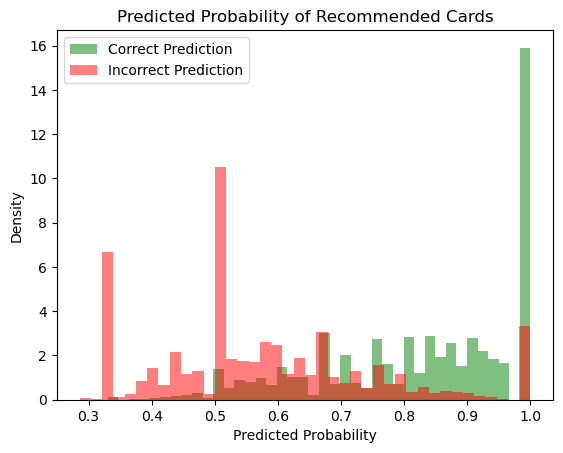

In [37]:
plt.hist(right_preds.rec_prob, density=True, color="green", alpha=0.5, bins=40, label="Correct Prediction")
plt.hist(wrong_preds.rec_prob, density=True, color="red", alpha=0.5, bins=40, label="Incorrect Prediction")
plt.legend()
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Predicted Probability of Recommended Cards")
plt.show()

Next, plots for each of the four colors of cards, to see if there's certain characters that we have trouble recommending to:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


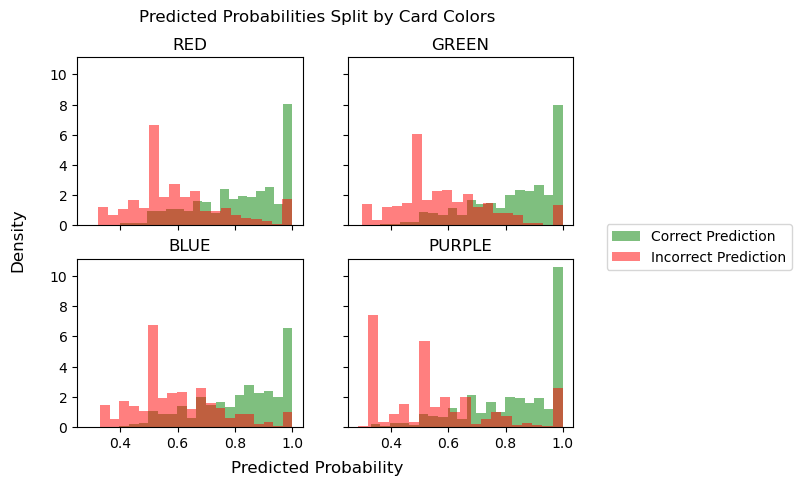

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex="all", sharey="all")
axes = {"RED": ax1, "GREEN": ax2, "BLUE": ax3, "PURPLE": ax4}
for col in ["RED", "GREEN", "BLUE", "PURPLE"]:
    col_preds_right = right_preds[right_preds.color == col]
    col_preds_wrong = wrong_preds[wrong_preds.color == col]
    
    axes[col].hist(col_preds_right.rec_prob, density=True, color="green", label="Correct Prediction", bins=20, alpha=0.5)
    axes[col].hist(col_preds_wrong.rec_prob, density=True, color="red", label="Incorrect Prediction", bins=20, alpha=0.5)
    axes[col].set_title(col)

    fig.suptitle("Predicted Probabilities Split by Card Colors")
    fig.supylabel("Density")
    fig.supxlabel("Predicted Probability")
    ax4.legend(loc="upper right", bbox_to_anchor=(2, 1.25))

Also, accuracy for each color:

In [18]:
for color in ["RED", "GREEN", "BLUE", "PURPLE"]:
    color_preds = preds[preds.color == color]
    acc = (color_preds.recommended == color_preds.picked).mean()
    print(f"Accuracy for color {color} = {acc}")

Accuracy for color RED = 0.8022186542110641
Accuracy for color GREEN = 0.8294495781438329
Accuracy for color BLUE = 0.7890798786653185
Accuracy for color PURPLE = 0.7378886478669558


I also want to figure out if we're under-recommending cards of certain rarities. We can take a look at all of our predictions and construct a table:

In [24]:
pd.crosstab(preds.rec_rarity, preds.picked_rarity, normalize='index')

picked_rarity,COMMON,RARE,UNCOMMON
rec_rarity,,,
COMMON,0.790249,0.050379,0.159372
RARE,0.006602,0.973590,0.019807
UNCOMMON,0.031451,0.026019,0.942530


In [20]:
pd.crosstab(wrong_preds.rec_rarity, wrong_preds.picked_rarity, normalize='index')

picked_rarity,COMMON,RARE,UNCOMMON
rec_rarity,,,
COMMON,0.290583,0.170392,0.539025
RARE,0.047714,0.809145,0.143141
UNCOMMON,0.237069,0.196121,0.566810


One more thing - I want to plot the accuracy of predictions per floor, to see where in the game our model is best.

In [21]:
preds["correct"] = (preds.recommended == preds.picked)
floor_acc = preds[["rec_floor", "correct"]].groupby("rec_floor").mean()
floor_acc

,correct
rec_floor,
0.0,0.760274
1.0,0.987490
2.0,0.945498
3.0,0.930962
4.0,0.901053
5.0,0.870476
6.0,0.848614
7.0,0.843798
8.0,0.812500


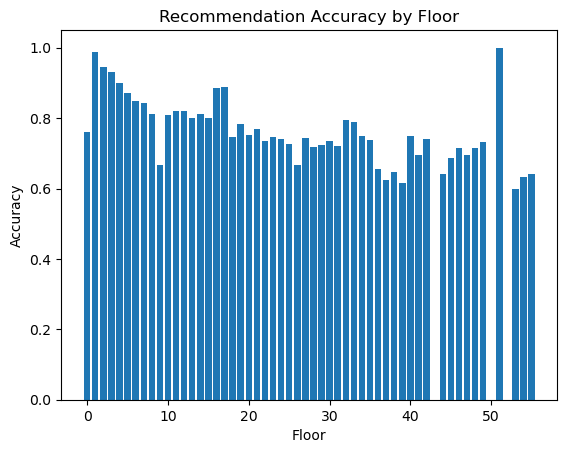

In [39]:
plt.bar(floor_acc.index, floor_acc.correct)
plt.title("Recommendation Accuracy by Floor")
plt.xlabel("Floor")
plt.ylabel("Accuracy")
plt.show()